In [141]:
import matplotlib.figure as figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dcekit.validation import mae_cce
from sklearn import datasets
from sklearn.cross_decomposition import PLSRegression
from sklearn.datasets import load_boston, make_regression
from sklearn.model_selection import GridSearchCV, train_test_split

In [142]:
boston = load_boston()
X, y = boston.data, boston.target

/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Calif

In [155]:
# -*- coding: utf-8 -*-
# %reset -f
import matplotlib.figure as figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
from sklearn.model_selection import train_test_split, GridSearchCV

class GPRegressor:
    def __init__(self, X, y, testsize=200, fold_number=5):
        self.X = X
        self.y = y
        self.testsize = testsize
        self.fold_number = fold_number
        
    def validation(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=self.testsize, random_state=0)
        X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
        y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
        X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
        
        return X_train, X_test, y_train, y_test
    
    def GPR(self):
        X_train, X_test, y_train, y_test = self.validation()
        
        kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
        ConstantKernel() * RBF() + WhiteKernel(),
        ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
        ConstantKernel() * RBF(np.ones(X_train.shape[1])) + WhiteKernel(),
        ConstantKernel() * RBF(np.ones(X_train.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),
        ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
        ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
        ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
        ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
        ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
        ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]
        
        cv_model = GridSearchCV(GaussianProcessRegressor(alpha=0), {'kernel': kernels}, cv=self.fold_number)
        cv_model.fit(X_train, y_train)
        optimal_kernel = cv_model.best_params_['kernel']
        model = GaussianProcessRegressor(optimal_kernel, alpha=0)
        model.fit(X_train, y_train)
        
        return model
    
    def calcurated(self):
        X_train, X_test, y_train, y_test = self.validation()
        model = self.GPR()
        calculated_y_train = model.predict(X_train) * y_train.std(ddof=1) + y_train.mean()
        
        # r2, RMSE, MAE
        print('r2: {0}'.format(float(1 - sum((y_train - calculated_y_train) ** 2) / sum((y_train - y_train.mean()) ** 2))))
        print('RMSE: {0}'.format(float((sum((y_train - calculated_y_train) ** 2) / len(y_train)) ** 0.5)))
        print('MAE: {0}'.format(float(sum(abs(y_train - calculated_y_train)) / len(y_train))))
        
        return calculated_y_train
        
    def calcplot(self):
        X_train, X_test, y_train, y_test = self.validation()
        calculated_y_train = self.calcurated()
        
        # yy-plot
        plt.rcParams['font.size'] = 18
        plt.figure(figsize=figure.figaspect(1))
        plt.scatter(y_train, calculated_y_train, c='crimson')
        y_max = np.max(np.array([np.array(y_train), calculated_y_train]))
        y_min = np.min(np.array([np.array(y_train), calculated_y_train]))
        plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
                 [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
        plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
        plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
        plt.xlabel('Actual Y')
        plt.ylabel('Calculated Y')
        plt.show()
        
    def prediction(self):
        X_train, X_test, y_train, y_test = self.validation()
        model = self.GPR()
        
        # prediction
        predicted_y_test, predicted_y_test_std = model.predict(X_test, return_std=True)
        predicted_y_test = predicted_y_test * y_train.std(ddof=1) + y_train.mean()
        predicted_y_test_std = predicted_y_test_std * y_train.std(ddof=1)
        
        # r2p, RMSEp, MAEp
        print('r2p: {0}'.format(float(1 - sum((y_test - predicted_y_test) ** 2) / sum((y_test - y_test.mean()) ** 2))))
        print('RMSEp: {0}'.format(float((sum((y_test - predicted_y_test) ** 2) / len(y_test)) ** 0.5)))
        print('MAEp: {0}'.format(float(sum(abs(y_test - predicted_y_test)) / len(y_test))))
        print('')
        return  predicted_y_test, predicted_y_test_std
        
    def pred_yyplot(self):
        predicted_y_test, predicted_y_test_std = self.prediction()
        X_train, X_test, y_train, y_test = self.validation()
        
        # yy-plot
        plt.figure(figsize=figure.figaspect(1))
        plt.scatter(y_test, predicted_y_test, c='crimson')
        y_max = np.max(np.array([np.array(y_test), predicted_y_test]))
        y_min = np.min(np.array([np.array(y_test), predicted_y_test]))
        plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
                 [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
        plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
        plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
        plt.xlabel('Actual Y')
        plt.ylabel('Predicted Y')
        plt.show()
        
    def sigmaplot(self):
        predicted_y_test, predicted_y_test_std = self.prediction()
        X_train, X_test, y_train, y_test = self.validation()
        
        plt.scatter(predicted_y_test_std, abs(y_test - predicted_y_test), c='crimson')
        plt.xlabel('Std. of estimated Y')   
        plt.ylabel('Error of Y')
        plt.show()

In [158]:
gpr = GPRegressor(X, y, testsize=100)

/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  Con

r2p: -5.954814780982435
RMSEp: 23.975522934860045
MAEp: 22.184999999999995



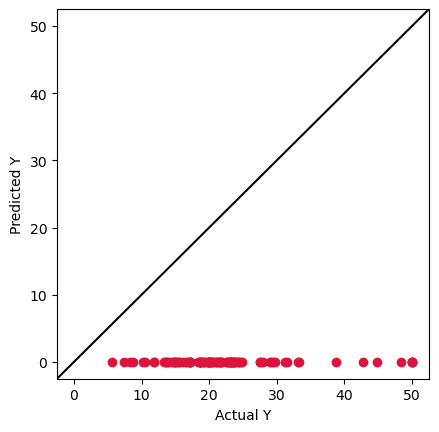

In [159]:
gpr.pred_yyplot()

/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  Conver

r2p: -0.0024677783087088123
RMSEp: 0.8478657939800214
MAEp: 0.6865089734406576



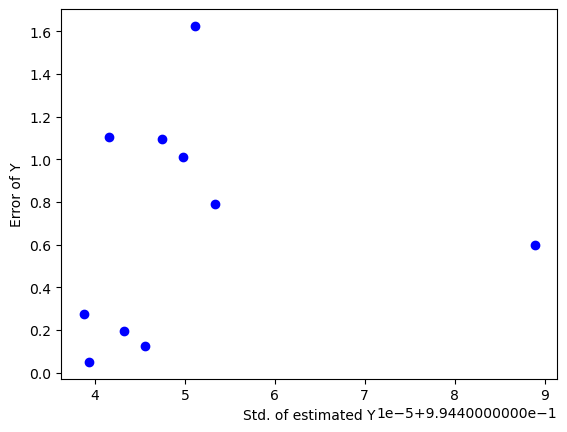

In [53]:
GPR.sigmaplot()